In [1]:
import random
import json
from dataclasses import dataclass, field
from typing import Optional

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import (
    EvalPrediction,
    Trainer,
    default_data_collator,
    TrainingArguments,
    HfArgumentParser
)

In [2]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )

@dataclass
class DataArguments:
    fold: int = field()
    k: int = field()
        
training_args = TrainingArguments('/home/nlp/experiments/edit')

In [8]:
with open("../data/synthetic_third.json", "r") as read_file:
    data = json.load(read_file)

df = pd.DataFrame(data)

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

In [35]:
context = 'abstract'
max_length = 128

In [36]:
def preprocess_function(examples):
    prompt = str(examples[context])
    choice_0, choice_1, choice_2, choice_3 = str(examples['thesis']), str(examples['anti-thesis']), str(examples['third-option']), str(examples['neg-thesis'])
    choices = [choice_0, choice_1, choice_2, choice_3]
    # Specify max_length=512 in encoding when not using body
    encoding = tokenizer([prompt, prompt, prompt, prompt], choices, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    encoding["label"] = 0
    return encoding


five_fold = {0: list(range(0, 168)),
             1: list(range(168, 336)),
             2: list(range(336, 504)),
             3: list(range(504, 672)),
             4: list(range(672, 840))}

In [37]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [38]:
predicted_labels = []
gold_labels = []

for i in range(len(five_fold)):
    valid_indexes = list(set(five_fold[i]))
    df = pd.DataFrame(data)
    eval_dataset = Dataset.from_pandas(df.iloc[valid_indexes])
    eval_dataset = eval_dataset.map(preprocess_function)
    model = AutoModelForMultipleChoice.from_pretrained('/home/nlp/experiments/edit_synthetic/third_option/lf_'+context+'/'+str(i), return_dict=True)
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
    )
    output_vals = trainer.predict(eval_dataset)
    val_labels = []
    for j in eval_dataset:
        val_labels.append(j["label"])
        
    gold_labels.extend(val_labels)
    predicted_labels.extend(np.argmax(output_vals.predictions, axis=1))

/home/nlp/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [39]:
len(gold_labels), len(predicted_labels)

(840, 840)

In [40]:
categories = {0: 'thesis', 1: 'anti', 2: 'third', 3: 'neg-thesis'}

In [41]:
gold_labels_word, predicted_labels_word = [], []
for i in range(len(gold_labels)):
    gold_labels_word.append(categories[gold_labels[i]])
    predicted_labels_word.append(categories[predicted_labels[i]])

In [42]:
conf = confusion_matrix(gold_labels, predicted_labels)

In [43]:
Counter(predicted_labels)

Counter({0: 687, 1: 110, 3: 43})

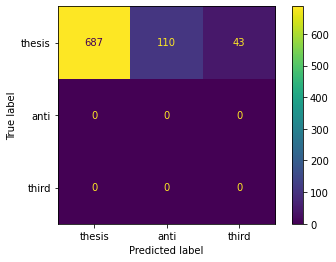

In [44]:
cmd = ConfusionMatrixDisplay(conf, display_labels=['thesis', 'anti', 'third',  'neg-thesis'])
cmd.plot()

In [45]:
cmd.figure_.savefig('synthetic_third_' + context + '.pdf')

In [11]:
# tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")
# model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-summarize-news").cuda()

# tokenizer = AutoTokenizer.from_pretrained("google/pegasus-multi_news")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-multi_news").cuda()
# stokenizer = AutoTokenizer.from_pretrained("sentence-transformers/roberta-large-nli-stsb-mean-tokens")
# smodel = AutoModel.from_pretrained("sentence-transformers/roberta-large-nli-stsb-mean-tokens").cuda()

# def summarize(text, max_length=8192):
#     input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True).cuda()
#     generated_ids = model.generate(input_ids=input_ids, num_beams=2, max_length=max_length,  repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
#     preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
#     return preds[0]

# cos = nn.CosineSimilarity(dim=0, eps=1e-6)

# correct_preds = 0
# for i in trange(len(data)):
#     print(i)
#     input_data = summarize(data[i]['body'])
#     print(len(data[i]['body']))
#     sentences = [input_data, data[i]['thesis'], data[i]['anti-thesis'], data[i]['third-option']]
#     encoded_input = stokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')
#     for k, v in encoded_input.items():
#         encoded_input[k] = v.cuda()
#     with torch.no_grad():
#         model_output = smodel(**encoded_input)
#     sentence_embeddings = MeanPooling(model_output[0], encoded_input['attention_mask'])
#     sim_array = [cos(sentence_embeddings[0], sentence_embeddings[1]),
#                 cos(sentence_embeddings[0], sentence_embeddings[2]),
#                 cos(sentence_embeddings[0], sentence_embeddings[3])]
#     pred_idx = sim_array.index(max(sim_array))
#     if pred_idx == 0:
#         correct_preds += 1